### Загрузка датасета и его предобработка
Выполним загрузку обогащенного датасета, который мы использовали для обучения классических моделей машинного обучения ранее. После этого выполним предобработку данных, удалив пропуски, ненужные столбцы и заменив значения в столбце atm_group на названия банков.   

In [1]:
import pandas as pd

df = pd.read_csv("train_with_district_region.csv", sep=",")
assert df.shape == (6261, 58)

# заменяем значения в столбце atm_group на названия банков
df['atm_group'] = df['atm_group'].replace({8083.0: 'Rosbank',
                                           1022.0: 'AkBars',
                                           1942.0: 'Alfabank',
                                           3185.5: 'Gazprombank',
                                           32.0: 'Raiffeisen',
                                           496.5: 'Rosselkhozbank',
                                           5478.0: 'Uralsib'})

# Удаляем строки с пропущенными значениями
df = df[df[['locality_area', 'locality_population', 'city', 'lat', 'bank']].notnull().all(axis=1)]

# Удаляем ненужные столбцы 
df.drop(['city_area', 'city_district', 'address', 'address_rus', 'metro', 'Unnamed: 0', 'id', 'oktmo'], axis=1, inplace=True)

# проверяем, что пропусков нет и что размер датасета соответствует ожидаемому
assert df.isna().sum().sum() == 0 
assert df.shape == (6029, 50)

Далее - используем созданные нами ранее объекты `Imputer`, `Encoder` и `Scaler` для предобработки данных.

In [2]:
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

with open("Imputer.pickle", "rb") as f:
    imputer: SimpleImputer = pickle.load(f)
with open("Encoder.pickle", "rb") as f:
    encoder: OneHotEncoder = pickle.load(f)
with open("Scaler.pickle", "rb") as f:
    scaler: StandardScaler = pickle.load(f)

In [ ]:
X = df.drop(columns=['target'])
y = df['target']

X[X.columns] = imputer.transform(X)

# кодируем категориальные признаки
cat_cols = ['atm_group', 'federal_district', 'city', 'region_with_type']
encoded_columns_df = pd.DataFrame(encoder.transform(X[cat_cols]).toarray(),
                                  columns=encoder.get_feature_names_out(cat_cols),
                                  dtype=int)
X = pd.concat(
    [
        X.drop(columns=cat_cols).reset_index(drop=True),
        encoded_columns_df.reset_index(drop=True)
    ],
    axis=1
)

# масштабируем признаки
X = pd.DataFrame(scaler.transform(X), columns=X.columns)
assert X.shape == (6029, 719)

### Вспомогательные функции для обучения нейронной 
Теперь подготовим ряд функций, которые будем использовать для обучения нейронных сетей.

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
from IPython.display import clear_output

plt.rcParams.update({'font.size': 16})
sns.set_style('whitegrid')
np.random.seed(0xFA1AFE1)

In [15]:
def plot_losses(train_losses, train_metrics, val_losses, val_metrics):
    """
    Отображает графики изменения функции потерь и метрики на обучающей и валидационной выборках
    """
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label='train')
    axs[1].plot(range(1, len(val_metrics) + 1), val_metrics, label='val')

    if max(train_losses) / min(train_losses) > 10:
        axs[0].set_yscale('log')

    if max(train_metrics) / min(train_metrics) > 10:
        axs[0].set_yscale('log')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    axs[0].set_ylabel('loss')
    axs[1].set_ylabel('metric')
    plt.show()


def train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader,
                       num_epochs, verbose=True, scheduler = None):
    """
    Выполняет обучение и валидацию нейронной сети
      - model: нейронная сеть для обучения
      - optimizer: оптимизатор, используемый для обучения
      - criterion: функция потерь, используемая для обучения
      - metric: метрика, используемая для оценки качества модели
      - train_loader: DataLoader с обучающей выборкой
      - val_loader: DataLoader с валидационной выборкой
      - num_epochs: количество эпох обучения
      - verbose: определяет, выводить ли информацию о процессе обучения
      - scheduler: опциональный параметр, позволяющий использовать планировщик для изменения learning rate 
    """
    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, running_metric = 0, 0
        pbar = tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}') \
            if verbose else train_loader

        for i, (X_batch, y_batch) in enumerate(pbar, 1):
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                metric_value = metric(y_batch, predictions)
                if type(metric_value) == torch.Tensor:
                    metric_value = metric_value.item()
                running_loss += loss.item() * X_batch.shape[0]
                running_metric += metric_value * X_batch.shape[0]

            if verbose and i % 100 == 0:
                pbar.set_postfix({'loss': loss.item(), 'metric': metric_value})

        train_losses += [running_loss / len(train_loader.dataset)]
        train_metrics += [running_metric / len(train_loader.dataset)]

        model.eval()
        running_loss, running_metric = 0, 0
        pbar = tqdm(val_loader, desc=f'Validating {epoch}/{num_epochs}') \
            if verbose else val_loader

        for i, (X_batch, y_batch) in enumerate(pbar, 1):
            with torch.no_grad():
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)

                metric_value = metric(y_batch, predictions)
                if type(metric_value) == torch.Tensor:
                    metric_value = metric_value.item()
                running_loss += loss.item() * X_batch.shape[0]
                running_metric += metric_value * X_batch.shape[0]

            if verbose and i % 100 == 0:
                pbar.set_postfix({'loss': loss.item(), 'metric': metric_value})

        val_losses += [running_loss / len(val_loader.dataset)]
        val_metrics += [running_metric / len(val_loader.dataset)]
        
        if scheduler is not None:
            scheduler.step()
        
        if verbose:
            plot_losses(train_losses, train_metrics, val_losses, val_metrics)
    
    if verbose:
        print(f'Validation metric: {val_metrics[-1]:.3f} (train metric: {train_metrics[-1]:.3f})')
    return val_metrics[-1], train_metrics[-1]

In [6]:
def get_data_loaders(X_train, y_train, X_val, y_val, batch_size=64):
    """
    Создает DataLoader-ы для обучения и валидации с использованием наборов параметров 
    X_train, X_val, y_train, y_val 
    """
    train_loader = DataLoader(
        TensorDataset(
            torch.tensor(X_train, dtype=torch.float32),
            torch.tensor(y_train, dtype= torch.float32),
        ),
        batch_size=batch_size,
        shuffle=True,
    )
    
    val_loader = DataLoader(
        TensorDataset(
            torch.tensor(X_val, dtype=torch.float32),
            torch.tensor(y_val, dtype= torch.float32),
        ),
        batch_size=batch_size,
        shuffle=False,
    )
    return train_loader, val_loader

### Подготовка данных
Разобьем данные на обучающую и валидационную выборки, определим основные гиперпараметры обучения и создадим DataLoader-ы.

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X.iloc[:,].values, y.iloc[:,].values, test_size=0.3, random_state=42)
y_train = y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)

In [10]:
train_loader, val_loader = get_data_loaders(X_train, y_train, X_val, y_val)

### Обучение нейронной сети
Сначала определим основные параметры процесса обучения. Будем использовать скрытый слой из 256 нейронов, 60 эпох для обучения,MSE в качестве функции потерь и R2 в качестве метрики. 

In [11]:
from sklearn.metrics import r2_score

HIDDEN_SIZE = 256
INPUT_SIZE = X_train.shape[1]
OUTPUT_SIZE = 1
NUMBER_OF_EPOCHS = 60

criterion = nn.MSELoss()
metric = r2_score

In [17]:
models_info = {}

Сначала обучим простую нейронную сеть с одним скрытым слоем. В качестве оптимизатора будем использовать SGD с learning rate 1e-2 и momentum 0.9.

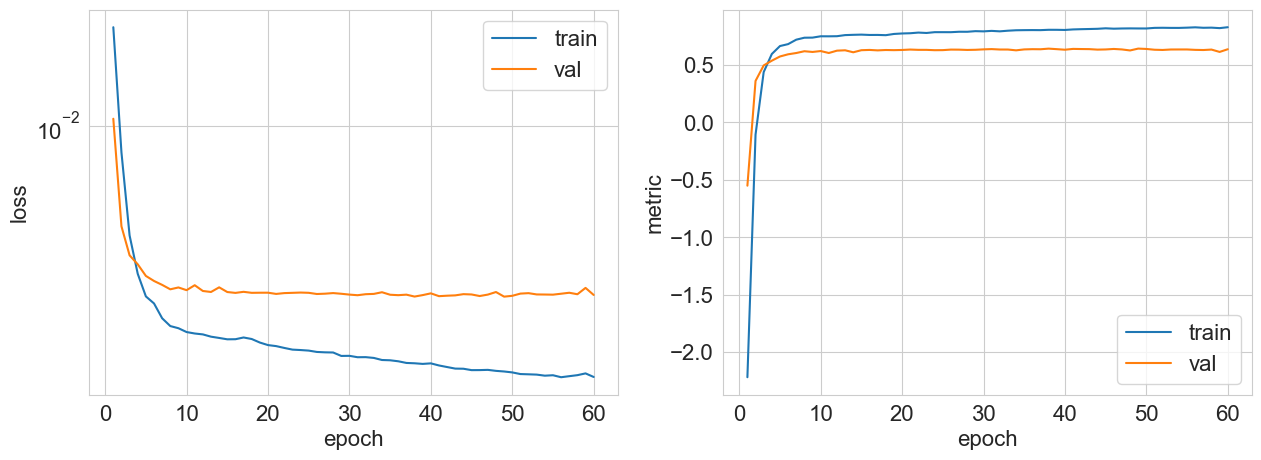

Validation metric: 0.638 (train metric: 0.830)


In [23]:
model = nn.Sequential(
    nn.Linear(INPUT_SIZE, HIDDEN_SIZE),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, 1),
)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

val_r2, train_r2 = train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader, NUMBER_OF_EPOCHS, verbose=True)
models_info['simple 1'] = {
    'model name': '1 скрытый слой, SGD-оптимизатор с lr=1e-2 и momentum=0.9', 
    'r2 on validation': val_r2, 
    'r2 on train': train_r2
}

Получившийся результат (R2 = 0,638) не лучше того, что был получен нами ранее с использованием классических моделей машинного обучения (напомним, там Lasso-регрессия давала R2 ~ 0,68, а оптимальное значение R2 было получено с использованием стекинга и было в районе 0.73). Кроме того, видим, что модель переобучается.

Попробуем добавить в сеть dropout-слой.

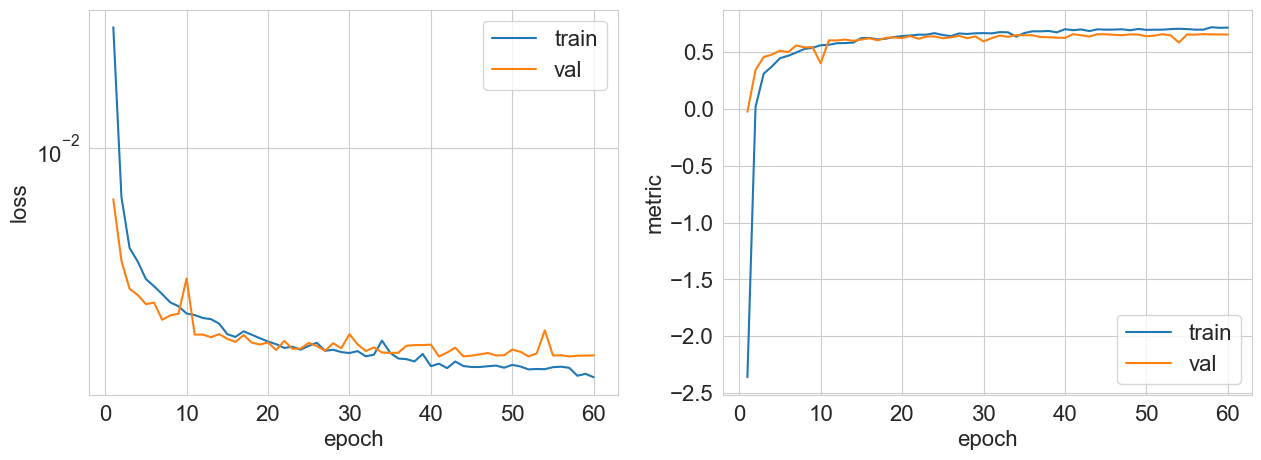

Validation metric: 0.653 (train metric: 0.715)


In [25]:
model = nn.Sequential(
    nn.Linear(INPUT_SIZE, HIDDEN_SIZE),
    nn.Dropout(p=0.15),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, 1),
)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
val_r2, train_r2 = train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader, NUMBER_OF_EPOCHS, verbose=True)
models_info['simple 2'] = {
    'model name': '1 скрытый слой, SGD-оптимизатор с lr=1e-2 и momentum=0.9 и dropout-слои', 
    'r2 on validation': val_r2, 
    'r2 on train': train_r2
}

Результат стал чуть лучше, а переобучение уменьшилось, но этого по прежнему недостаточно. 
Попробуем использовать другой оптимизатор - Adam с learning rate 1e-4.

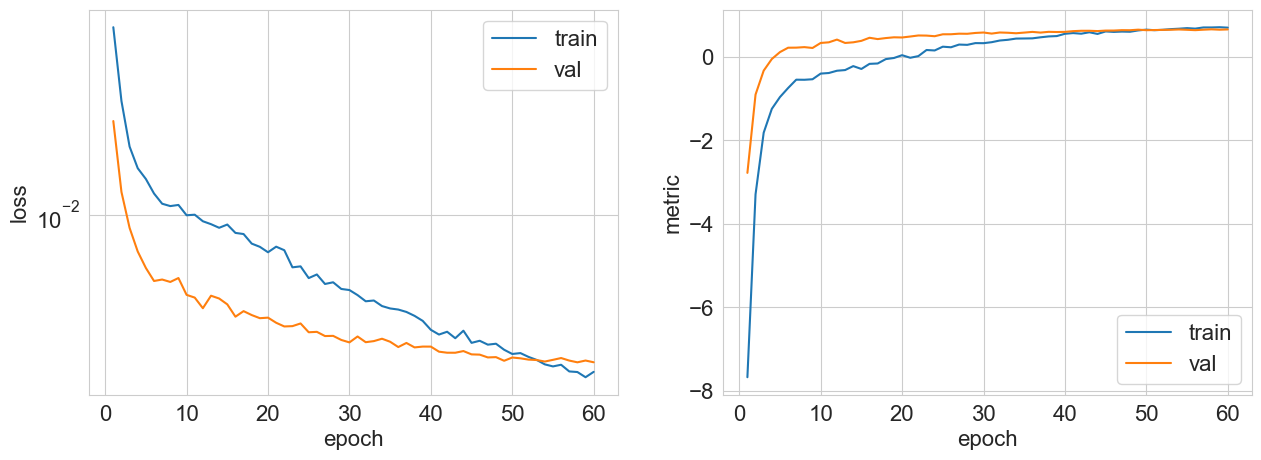

Validation metric: 0.654 (train metric: 0.696)


In [28]:
model = nn.Sequential(
    nn.Linear(INPUT_SIZE, HIDDEN_SIZE),
    nn.Dropout(p=0.15),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, 1),
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
val_r2, train_r2 = train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader, NUMBER_OF_EPOCHS, verbose=True)
models_info['simple 3'] = {
    'model name': '1 скрытый слой, Adam-оптимизатор с lr=1e-4 и dropout-слои', 
    'r2 on validation': val_r2, 
    'r2 on train': train_r2
}

R2 остался почти тем же, но немного уменьшилось переобучение. Попробуем добавить еще один скрытый слой.

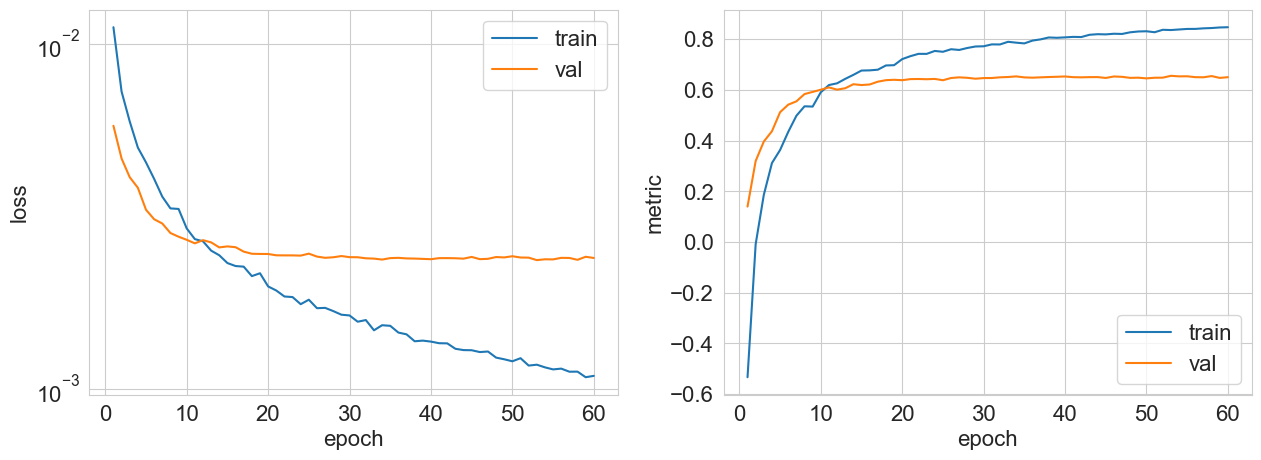

Validation metric: 0.650 (train metric: 0.847)


In [29]:
model = nn.Sequential(
    nn.Linear(INPUT_SIZE, HIDDEN_SIZE),
    nn.Dropout(p=0.15),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
    nn.Dropout(p=0.15),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, 1),
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
val_r2, train_r2 = train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader, NUMBER_OF_EPOCHS, verbose=True)
models_info['simple 4'] = {
    'model name': '2 скрытых слоя, Adam-оптимизатор с lr=1e-4 и dropout-слои', 
    'r2 on validation': val_r2, 
    'r2 on train': train_r2
}

При почти том же значении R2, увеличилось переобучение. Попробуем увеличить вероятность для dropout-слоев до 0.25.

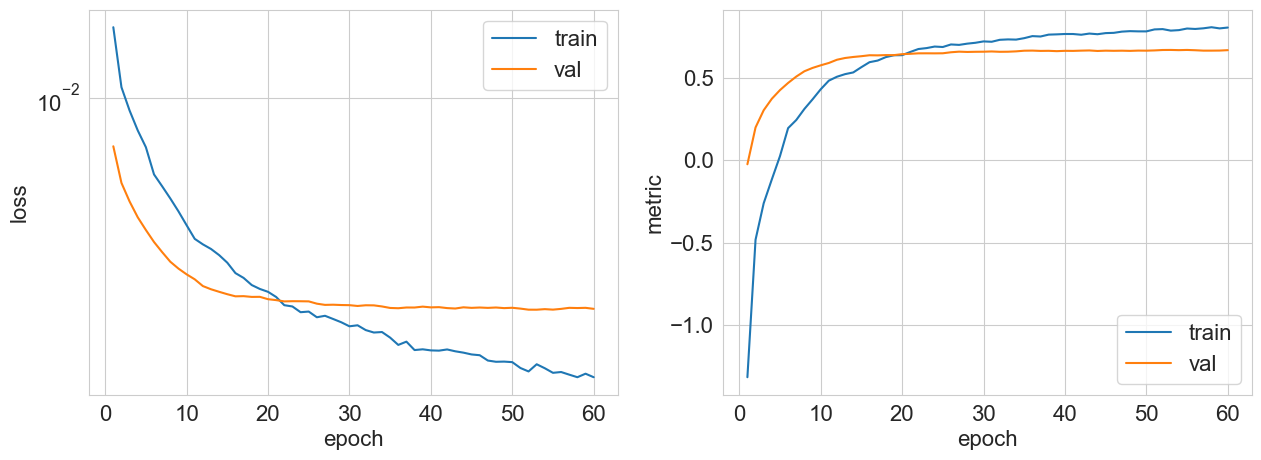

Validation metric: 0.668 (train metric: 0.805)


In [32]:
model = nn.Sequential(
    nn.Linear(INPUT_SIZE, HIDDEN_SIZE),
    nn.Dropout(p=0.25),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
    nn.Dropout(p=0.25),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, 1),
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
val_r2, train_r2 = train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader, NUMBER_OF_EPOCHS, verbose=True)
models_info['simple 5'] = {
    'model name': '2 скрытых слоя, Adam-оптимизатор с lr=1e-4 и dropout-слои с p=0.25', 
    'r2 on validation': val_r2, 
    'r2 on train': train_r2
}

Увеличение p до 0.25 для dropout-слоев немного улучшило метрику и сократило переобучение. 
Попробуем задать оптимизатору значение weight_decay=1e-6.

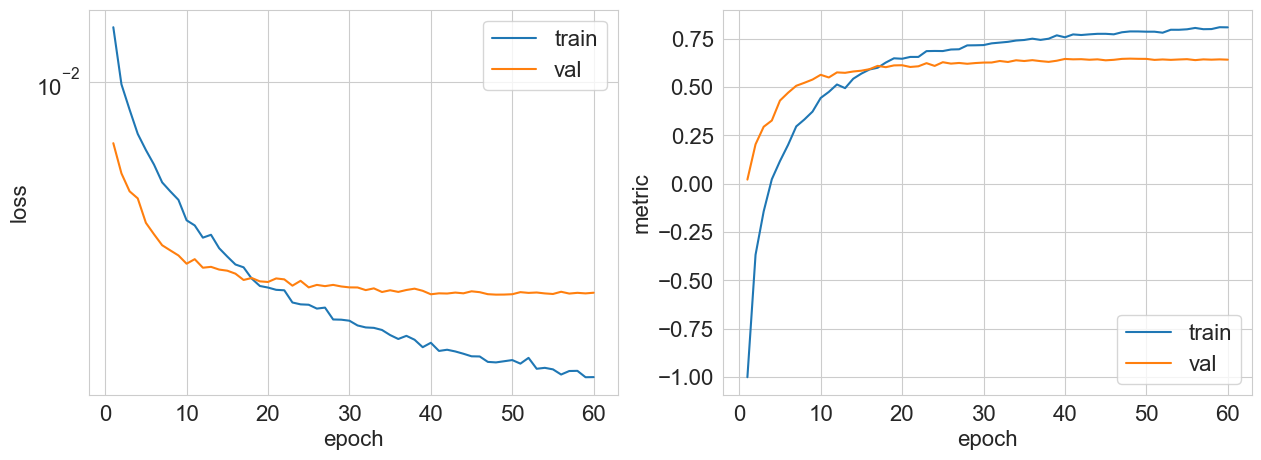

Validation metric: 0.641 (train metric: 0.808)


In [33]:
model = nn.Sequential(
    nn.Linear(INPUT_SIZE, HIDDEN_SIZE),
    nn.Dropout(p=0.25),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
    nn.Dropout(p=0.25),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, 1),
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
val_r2, train_r2 = train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader, NUMBER_OF_EPOCHS, verbose=True)
models_info['simple 6'] = {
    'model name': '2 скрытых слоя, Adam-оптимизатор с lr=1e-4, dropout-слои с p=0.25 и weight_decay=1e-6', 
    'r2 on validation': val_r2, 
    'r2 on train': train_r2
}

R2 ухудшился, попробуем снизить weight_decay до 1e-3.

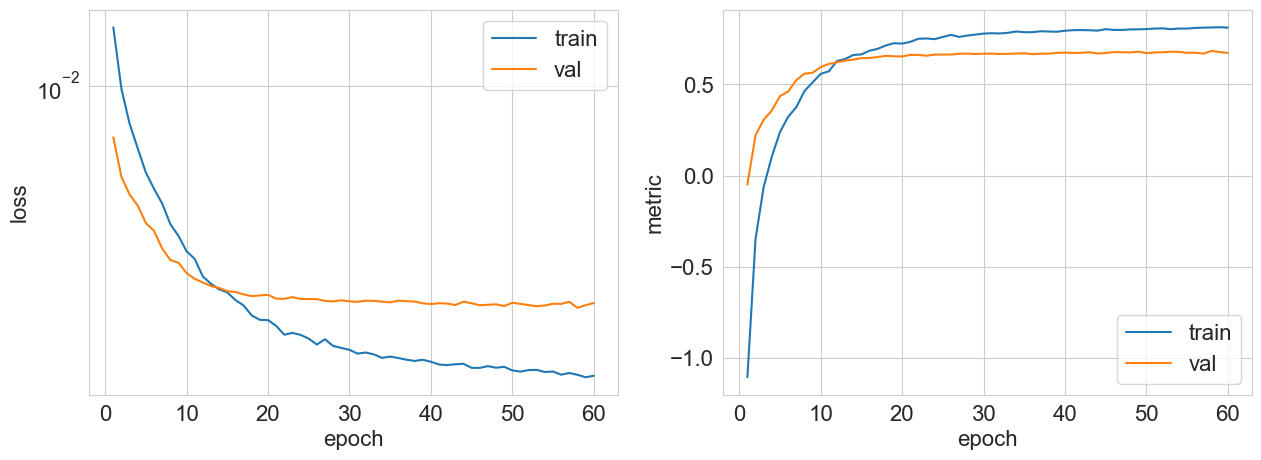

Validation metric: 0.672 (train metric: 0.810)


In [34]:
model = nn.Sequential(
    nn.Linear(INPUT_SIZE, HIDDEN_SIZE),
    nn.Dropout(p=0.25),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
    nn.Dropout(p=0.25),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, 1),
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
val_r2, train_r2 = train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader, NUMBER_OF_EPOCHS, verbose=True)
models_info['simple 7'] = {
    'model name': '2 скрытых слоя, Adam-оптимизатор с lr=1e-4, dropout-слои с p=0.25 и weight_decay=1e-3', 
    'r2 on validation': val_r2, 
    'r2 on train': train_r2
}

C weight decay=1e-3 результат немного лучше, чем с weight decay=1e-6. Хоть теперь это и лучший результат, до полученного ранее с использованием классических моделей машинного обучения все равно далеко.

Попробуем снижать значение learning rate по мере обучения.

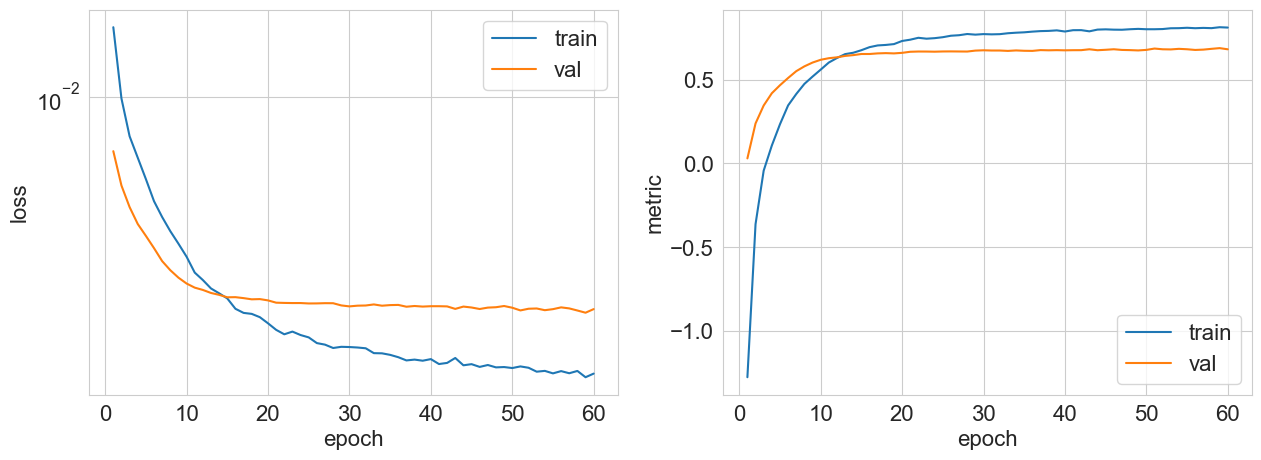

Validation metric: 0.681 (train metric: 0.811)


In [37]:
model = nn.Sequential(
    nn.Linear(INPUT_SIZE, HIDDEN_SIZE),
    nn.Dropout(p=0.25),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
    nn.Dropout(p=0.25),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, 1),
)

import torch.optim as optim
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 30], gamma=0.1)
val_r2, train_r2 = train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader, NUMBER_OF_EPOCHS, verbose=True)
models_info['simple 8'] = {
    'model name': '2 скрытых слоя, Adam-оптимизатор с lr=1e-4, dropout-слои с p=0.25 и weight_decay=1e-3, lr scheduler', 
    'r2 on validation': val_r2, 
    'r2 on train': train_r2
}

Качество удалось еще немного подтянуть. Попробуем другие пороги изменения learning rate.

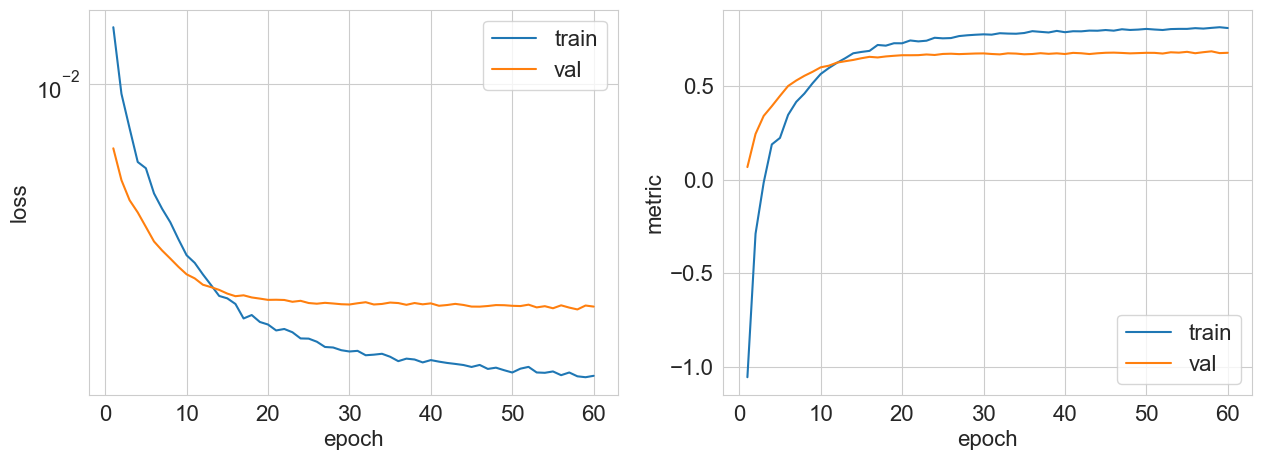

Validation metric: 0.679 (train metric: 0.811)


In [38]:
model = nn.Sequential(
    nn.Linear(INPUT_SIZE, HIDDEN_SIZE),
    nn.Dropout(p=0.25),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
    nn.Dropout(p=0.25),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, 1),
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 30, 45], gamma=0.1)
val_r2, train_r2 = train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader, NUMBER_OF_EPOCHS, verbose=True)
models_info['simple 9'] = {
    'model name': '2 скрытых слоя, Adam-оптимизатор с lr=1e-4, dropout-слои с p=0.25 и weight_decay=1e-3, lr scheduler 3 steps', 
    'r2 on validation': val_r2, 
    'r2 on train': train_r2
}

Получилось чуть хуже. 

В целом, складывается ощущение, что для качества нейронной сети значение R2 = 0.68 является неким потолком. Мы попробуем еще один вариант - сеть с четырьмя скрытыми слоями и числом нейронов в них 64.

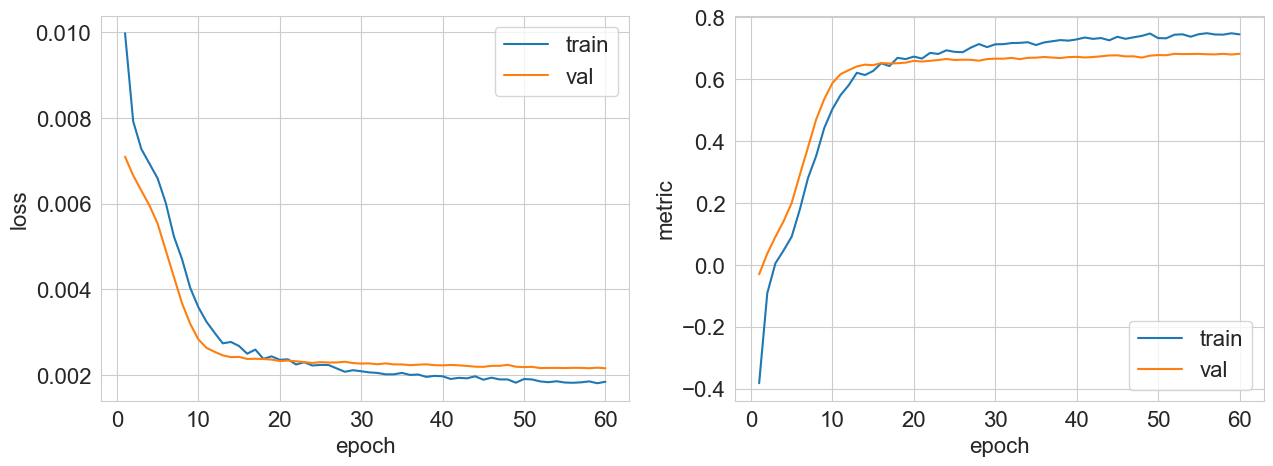

Validation metric: 0.682 (train metric: 0.745)


In [40]:
HIDDEN_SIZE = 64
model = nn.Sequential(
    nn.Linear(INPUT_SIZE, HIDDEN_SIZE),
    nn.Dropout(p=0.25),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
    nn.Dropout(p=0.25),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
    nn.Dropout(p=0.25),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
    nn.Dropout(p=0.25),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, 1),
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 30], gamma=0.1)
val_r2, train_r2 = train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader, NUMBER_OF_EPOCHS, verbose=True)
models_info['simple 10'] = {
    'model name': '4 скрытых слоя, Adam-оптимизатор с lr=1e-4, dropout-слои с p=0.25 и weight_decay=1e-3, lr scheduler', 
    'r2 on validation': val_r2, 
    'r2 on train': train_r2
}

### Заключение

В результате усложнения мы получили еще чуть большее значение R2, и при этом переобучение сократилось. Но даже эта модель не смогла побить качество, полученное при использовании классических моделей машинного обучения. Соответственно, разрабатываемый в рамках проекта сервис предсказания популярности банкоматов по их местоположению по прежнему будет работать на основе классической модели машинного обучения.

Неспособность нейронной сети обеспечить сравнимое качество может быть связано с тем, что обучающая выборка достаточно мала, в то время как для обучения нейронных сетей требуется большое количество данных.  


### Сводная таблица метрик качества нейронных сетей, обученных в рамках работы

In [46]:
pd.DataFrame(models_info.values()).sort_values(by='r2 on validation', ascending=False)

,model name,r2 on validation,r2 on train
9,"4 скрытых слоя, Adam-оптимизатор с lr=1e-4, dr...",0.682113,0.744903
7,"2 скрытых слоя, Adam-оптимизатор с lr=1e-4, dr...",0.681233,0.810898
8,"2 скрытых слоя, Adam-оптимизатор с lr=1e-4, dr...",0.678644,0.811079
6,"2 скрытых слоя, Adam-оптимизатор с lr=1e-4, dr...",0.671859,0.810132
4,"2 скрытых слоя, Adam-оптимизатор с lr=1e-4 и d...",0.668062,0.805312
2,"1 скрытый слой, Adam-оптимизатор с lr=1e-4 и d...",0.654042,0.696451
1,"1 скрытый слой, SGD-оптимизатор с lr=1e-2 и mo...",0.653216,0.714970
3,"2 скрытых слоя, Adam-оптимизатор с lr=1e-4 и d...",0.650003,0.847036
5,"2 скрытых слоя, Adam-оптимизатор с lr=1e-4, dr...",0.640628,0.807660
0,"1 скрытый слой, SGD-оптимизатор с lr=1e-2 и mo...",0.637995,0.829813
